# Existential Risk Model Solution with Value Function Iteration

This notebook is part of a computational appendix that accompanies the paper

> Existential Risk and The Fermi Paradox
> > Mahon (2021)

Code is adapted from [7 Solution Methods to Solve the Neoclassical Growth Model with Python](https://notes.quantecon.org/submission/5b5f70db9cd7f00015be634e) from the computational appendix of *MATLAB, Python, Julia: What to Choose in Economics?* by Coleman, Lyon, Maliar, and Maliar (2017). 


In [2517]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
import time
import quantecon as qe
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.misc import derivative
from interpolation.complete_poly import (CompletePolynomial,
                                         n_complete, complete_polynomial,
                                         complete_polynomial_der,
                                         _complete_poly_impl,
                                         _complete_poly_impl_vec,
                                         _complete_poly_der_impl,
                                         _complete_poly_der_impl_vec)
from numba import jit, vectorize

## Model Description

There is a fixed population of N homogeneous agents who live up to an infinite number of periods.

There are two control variables: consumption ($ c $), and existential risk mitigation $( w )$. Agents maximize their expected lifetime utility with respect to these two variables. 

The are two state variables: a general [common-pool resource](https://en.wikipedia.org/wiki/Common-pool_resource) (CPR), $ X $, and [total-factor productivity](https://en.wikipedia.org/wiki/Total_factor_productivity) (TFP), $ A $. Each agent's production function relies on how much of the CPR they extract $ x_i $, multiplied by $ A $.   
$$
\begin{equation}
    f(x_i, A) = Ax_i \tag{production function}
\end{equation}
$$    
    
Thus, we have the following for the budget constraint: 
$$ 
\begin{align}
    c_i + w_i &\leq Ax_i \tag{B.C.} \\
    \sum_{i=1}^N x_i &\leq X \\
    \implies C + W &\leq AX; \;\; \text{ where } C \equiv \sum_{i=1}^N c_i, \text{ and } W \equiv \sum_{i=1}^N w_i
\end{align}
$$
Whatever CPR remains at the end of a period goes to the next period multiplied by an exogenous rate of replenishment $ g_x $. Using the notation that primes mean a variables value in the next period, we get the following for the law of motion for the CPR. 
$$
\begin{align}
    X' &= ( X - \sum_{i=1}^N x_i )(1 + g_x) \tag{CPR LLM }\\
    &= (X - \frac{C + W}{A})( 1 + g_x )
\end{align}
$$
     
The TFP grows at a constant exponential rate, $ g_a $:
$$
\begin{equation}
    A' = A(1 + g_a)
\end{equation}
$$  

We can combine these last two equations by multiplying the CPR LLM by $  A(1 + g_a) $:
$$
\begin{equation}
    A'X' = (AX - C - W)( 1 + g_x )(1 + g_a) 
\end{equation}
$$ 
    
To simply, denote $ \tilde{X} := A'X' $ and $ g := g_x + g_a + g_x g_a $, such that $ ( 1 + g) = ( 1 + g_x)(1 + g_a) $. Now the problem can be expressed in terms of a single state variable, $ \tilde{X} $. 
$$
\begin{align}
    \tilde{X}' &= (\tilde{X} - C - W)( 1 + g) \\
    C + W &\leq \tilde{X} 
\end{align}
$$ 


The instantaneous utility is a log-utility functon, and we assume the utility of death is zero, i.e. agents are indifferent to being dead and consuming just 1 unit of consumption because $\ln(1) = 0 $, and they prefer death over $ c < 1 $, and prefer life over $ c > 1 $. Future utility is discounted by the subjective discount factor, $ \beta \in [0,1) $. 

There is endogenous probability of civilization ending due to an existential disaster at the end of each period based on the ratio of the current period's total consumption, $ C $, and total existential risk mitigation, $ W $. The scalar constant, $ \bar{a} $, scales the relative effect of $ W $ versus $ C $ on this probability. 
$$
\Pr(\text{ Existiential Disaster } | C, W ) = \frac{C}{C + \bar{a} W}
$$

The agent's problem can be written recursively using the following Bellman equation:

$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta E \bigl[V(\tilde{X}') | C, W\bigr] \biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

Note:
$$
\begin{align}
    E \bigl[V(\tilde{X}') | C, W\bigr] &= \bigg( 1 - \Pr(\text{ Existiential Disaster } | C, W )\bigg)V(\tilde{X}') \\
    &= \frac{\bar{a}W}{C + \bar{a} W}V(\tilde{X}') 
\end{align} 
$$
    
Thus, the problem can be expressed deterministically:
$$
\begin{align*}
    V(\tilde{X}) &= \max_{c_i,w_i} \biggl\{\ln(c_i) + \beta \frac{\bar{a}W}{C + \bar{a} W} V(\tilde{X}')\biggr\}\\
    & \text{ s.t. } c_i \geq 0; \qquad s_i \geq 0 \\
    & \phantom{\text{ s.t. } } C + W \leq \tilde{X}\\
    & \phantom{\text{ s.t. } } \tilde{X}' = (\tilde{X} - C - W)(1 + g) 
\end{align*} 
$$

## Python Code

We begin by defining a `namedtuple` that contains the parameters of our model. This is useful to pass the parameters around to functions that are just-in-time (JIT) compiled by `numba`.

In [2518]:
#
# Create a named tuple type that we can pass into the jitted functions
# so that we don't have to pass parameters one by one
#
Params = namedtuple("Params", ["N", "beta", "g", "a_bar", "eta", "u_bar"])

@jit(nopython=True)
def param_unpack(params):
    "Unpack parameters from the Params type"
    out = (params.N, params.beta, params.g,
           params.a_bar, params.eta, params.u_bar)

    return out

We will then define various helper functions to ensure that we [don't repeat ourselves](https://lectures.quantecon.org/py/writing_good_code.html#don-t-repeat-yourself) and that the inner functions can be JIT compiled.

In [2519]:
#
# Helper functions to make sure things are jitted
#
@vectorize(nopython=True)
def u(c, eta, u_bar):
    "log utility function"
    return -1e10 if c < 1e-10 else (u_bar + np.log(c)) if eta==1 else (u_bar + (c**(1-eta)/(1-eta)))

@vectorize(nopython=True)
def du(c,eta):
    "Derivative of log utility function"
    return 1e10 if c < 1e-10 else c**(-eta)

@vectorize(nopython=True)
def duinv(u,eta):
    "Inverse of the derivative of the CRRA utility function"
    return u**(-1.0/eta )

@vectorize(nopython=True)
def f(X):
    "production function"
    return X

@vectorize(nopython=True)
def df(X):
    "Derivative of production function"
    return 1

@vectorize(nopython=True)
def discount_factor(beta, a_bar, c, w):
    "risk adjusted discount factor"
    return beta*a_bar*w/(c + a_bar*w)

@vectorize(nopython=True)
def next_x(X, N, g, c, w):
    # next period's CPR given c and w
    return (X - N*(c + w))*(1+g)

@vectorize(nopython=True)
def vector_dampen(vec1, vec2, dampen=1):
    return dampen*vec1 + (1-dampen)*vec2

@vectorize(nopython=True)
def expendables(X, Xp, N, g):
    # get expendables given X and X prime
    return (1/N)*(X - Xp/(1 + g))

@vectorize(nopython=True)
def c_from_X_Xp(X, Xp, Vp, beta, a):
    # get expendables given X and X prime
    return -(2*E*a - 2*E*a**2 + E*a*(Vp*beta*(4*a + Vp*beta - 4))**0.5 - E*Vp*a*beta)/(2*(a**2 - 2*a + 1))

@vectorize(nopython=True)
def c_from_exp(Vp, E, beta, a_bar):
    if Vp <= 0: 
        return E
    return -(2*E*a_bar - 2*E*a_bar**2 + E*a_bar*(Vp*beta*(4*a_bar + Vp*beta - 4))**0.5 - E*Vp*a_bar*beta)/(2*(a_bar**2 - 2*a_bar + 1))



def x_curve(x, a, b):
    return a + b*x


def v_curve(x, a, b, c, d):
    return a*np.log(x)/(c - (x**b)) + d


@vectorize(nopython=True)
def trunc_to_one(X):
    return X if X >= 1 else 1

@vectorize(nopython=True)
def psurvival(a_bar, c, w):
    return a_bar*w/(c + a_bar*w)


We also now define a class that contains

1. Parameters of the growth model
2. Grids used for approximating the solution
3. Nodes and weights used to approximate integration

This again helps us maintain all of the relevant information in one place and simplifies passing it to other functions.

In [2520]:
class Model(object):
    """
    The stochastic Neoclassical Growth model contains
    parameters which include

    * alpha: Capital share in output
    * beta: discount factor
    * delta: depreciation rate
    * gamma: risk aversion
    * rho: persistence of the log productivity level
    * sigma: standard deviation of shocks to log productivity
    """
    def __init__(self, N=1, beta=0.95, g_x=0.05, g_a=0.015, a_bar=1e5, 
                 eta=1, u_bar=0, 
                 xmin_l=2, xmax_l=200, nx_l=25, linspace_l=True,
                 xmin_h=250, xmax_h=2500, nx_h=100, linspace_h=False):
        # calculate g from g_a and g_x 
        g = g_a + g_x + g_a*g_x

        # Household parameters
        self.beta, self.eta, self.u_bar, = beta, eta, u_bar

        # Firm/technology parameters
        self.N, self.g, self.a_bar = N, g, a_bar

        # Create t grids
        if linspace_l:
            self.xgrid_l = N*np.linspace(xmin_l, xmax_l, nx_l)
        else:
            self.xgrid_l = N*np.geomspace(xmin_l, xmax_l, nx_l)
            
        if linspace_h:
            self.xgrid_h = N*np.linspace(xmin_h, xmax_h, nx_h)
        else:
            self.xgrid_h = N*np.geomspace(xmin_h, xmax_h, nx_h)
            
        self.xgrid = np.concatenate([self.xgrid_l, self.xgrid_h])
        # for splitting spline versus nonlin policy functions
        self.xsplit = self.xgrid_l[-1]
        self.xsplit_idx = nx_l
        
        self.ns = nx_l + nx_h
        
    def _unpack_params(self):
        out = (self.N, self.beta, self.g, 
               self.a_bar, self.eta, self.u_bar)
        return out

    def _unpack_grids(self):
        out = (self.xgrid)
        return out


## Solution Methods

In this notebook, we describe the following solution methods:

* Conventional Value Function Iteration
* Envelope Condition Value Function Iteration
* Envelope Condition Derivative Value Function Iteration
* Endogenous Grid Value Function Iteration
* Conventional Policy Function Iteration
* Envelope Condition Policy Function Iteration
* Euler Equation Method

Each of these solution methods will have a very similar structure that follows a few basic steps:

1. Guess a function (either value function or policy function).
2. Using this function, update our guess of both the value and policy functions.
3. Check whether the function we guessed and what it was updated to are similar enough. If so, proceed. If not, return to step 2 using the updated functions.
4. Output the policy and value functions.

In order to reduce the amount of repeated code and keep the exposition as clean as possible (the notebook is plenty long as is...), we will define a class for each solution method that inherit various properties from a general solution parent class. The parent class will contain methods which apply to all of the other solution methods such as a general solve method, computing expectations, simulating, etc... This implementation may feel strange at first if one isn't familiar with object oriented programming, but these concepts can be powerful when properly used.

In [2521]:
class GeneralSolution:
    """
    This is a general solution method. We define this, so that we can
    sub-class it and define specific update methods for each particular
    solution method
    """
    def __init__(self, ncgm, prev_sol=None, maxfev=10000, interpolator='linear'):
        # Save model and approximation degree
        self.ncgm,  self.maxfev, self.interpolator = ncgm, maxfev, interpolator

        # Unpack some info from ncgm
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        X = self.ncgm.xgrid
        self.xsplit = self.ncgm.xsplit
        self.xsplit_idx = self.ncgm.xsplit_idx
        

        # Use parameter values from model to create a namedtuple with
        # parameters saved inside
        self.params = Params(N, beta, g, a_bar, eta, u_bar)
        
        # initialize CP and WP as None:
        self.CP = None
        self.WP = None

        # Update to fill initial value and policy matrices
        # If we give it another solution type then use it to
        # generate values and policies
        if issubclass(type(prev_sol), GeneralSolution):
            self.XP = prev_sol.XP
            self.VF = prev_sol.VF
        # If we give it a tuple then assume it is (policy, value) pair
        elif type(prev_sol) is tuple:
            self.XP = prev_sol[0]
            self.VF = prev_sol[1]
        # Otherwise guess a constant value function and a policy
        # of roughly steady state
        else:
            # guess VF and XP
            self.VF = np.log(X/N) 
            self.XP = X

        # Fit spline based on guesses
        self.x_spline = interp1d(X[:self.xsplit_idx], self.XP[:self.xsplit_idx], kind=self.interpolator, fill_value='extrapolate')
        self.v_spline = interp1d(X[:self.xsplit_idx], self.VF[:self.xsplit_idx], kind=self.interpolator, fill_value='extrapolate')
        
        # Params based on guesses
        self.x_coeffs, _ = opt.curve_fit(x_curve
                                         , X[self.xsplit_idx:]
                                         , self.XP[self.xsplit_idx:]
                                         , maxfev=self.maxfev)
        self.v_coeffs, _ = opt.curve_fit(v_curve
                                         , X[self.xsplit_idx:]
                                         , self.VF[self.xsplit_idx:]
                                         , maxfev=self.maxfev)
  
    def build_VF(self, X=None):
        """
        Using the current coefficients, this builds the value function
        for all states
        """
        if X is None:
            X = self.ncgm.xgrid
        
        VF = np.where(X > self.xsplit
                        , v_curve(X, *self.v_coeffs)
                        , self.v_spline(X))

        return VF
    
    def build_XP(self, X=None):
        if X is None:
            X = self.ncgm.xgrid
        
        XP = np.where(X > self.xsplit
                        , np.clip(x_curve(X, *self.x_coeffs)
                                  , 0, X*(1 + self.ncgm.g))
                        , self.x_spline(X))
        
        return XP
    
    def compute_splines(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_spline = self.x_spline
        else:
            new_x_spline = interp1d(self.ncgm.xgrid[:self.xsplit_idx]
                                    , XP[:self.xsplit_idx]
                                    , kind=self.interpolator
                                    , fill_value='extrapolate')
        
        new_v_spline = interp1d(self.ncgm.xgrid[:self.xsplit_idx]
                                , VF[:self.xsplit_idx]
                                , kind=self.interpolator
                                , fill_value='extrapolate')
        
        return new_x_spline, new_v_spline
    
    
    def compute_coeffs(self, XP, VF):
        if isinstance(self, IterateOnPolicy):
            new_x_coeffs = self.x_coeffs
        else:
            new_x_coeffs, _ = opt.curve_fit(x_curve
                                            , self.ncgm.xgrid[self.xsplit_idx:]
                                            , XP[self.xsplit_idx:]
                                            , maxfev=self.maxfev)
        
        new_v_coeffs, _ = opt.curve_fit(v_curve
                                        , self.ncgm.xgrid[self.xsplit_idx:]
                                        , VF[self.xsplit_idx:]
                                        , maxfev=self.maxfev) 
        
        return new_x_coeffs, new_v_coeffs

    def _unpack_params(self):
        return self.ncgm._unpack_params()

    def build_CP(self, E=None, VP=None, X=None, XP=None):
        """
        Using the current coefficients, this builds the policy function
        for all states
        """
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        
        # Check if expected value next period (EVP) and expendables (E) are given
        if VP is None or E is None:
            if X is None:
                X = self.ncgm.xgrid
                
            if XP is None:
                XP = self.build_XP(X)
                
            VP = self.compute_EV(XP)
            E = expendables(X, XP, N, g)
            
        CP = np.clip(c_from_exp(VP, E, beta, a_bar), 0, np.maximum(E, 0))

        return CP
    
    def build_WP(self, CP=None, E=None, VP=None, X=None, XP=None):
        """
        Using the current coefficients, this builds the policy function
        for all states
        """
        if CP is None or E is None:
            N, beta, g, a_bar, eta, u_bar = self._unpack_params()
            if VP is None or E is None:
                if X is None:
                    X = self.ncgm.xgrid

                if XP is None:
                    XP = self.build_XP(X)

                VP = self.compute_EV(XP)
                E = expendables(X, XP, N, g)

                CP = np.clip(c_from_exp(VP, E, beta, a_bar), 0, X/N)
            else:
                CP = self.build_CP(E=E, VP=VP)
            
        return E - CP

    def update_v(self, new_v_coeffs, new_v_spline):
        """
        Updates the coefficients for the value function
        """
        self.v_coeffs = new_v_coeffs
        self.v_spline = new_v_spline

        return None

    def update_x(self, new_x_coeffs, new_x_spline):
        """
        Updates the coefficients for the policy function
        """
        self.x_coeffs = new_x_coeffs
        self.x_spline = new_x_spline
        
        return None

    def update(self):
        """
        Given the current state of everything in solution, update the
        value and policy coefficients
        """
        emsg = "The update method is implemented in solution specific classes"
        emsg += "\nand cannot be called from `GeneralSolution`"
        raise ValueError(emsg)


    def compute_EV(self, XP=None):
        """
        Compute the expected value
        """
        if XP is None:
            # Use policy to compute XP
            XP = self.build_XP()
        
        EV = self.build_VF(XP) 
        
        return EV


    def compute_distance(self, XP, VF):
        """
        Computes average distance between policy functions
        """
        return np.max(np.abs(1.0 - (XP+1e-12)/(self.XP+1e-12)))
    

    def solve(self, tol=1e-6, maxiter=2500, verbose=False, nskipprint=25):
        # Iterate until convergence
        dist, it = 10.0, 0
        while (dist>tol) and (it<maxiter):
            # Run solution specific update code
            XP, VF = self.update()
            

            # Compute new policy and value coeffs
            new_x_coeffs,  new_v_coeffs = self.compute_coeffs(XP, VF)
            new_x_spline, new_v_spline = self.compute_splines(XP, VF)

            # Update distance and iterations
            dist = self.compute_distance(XP, VF)
            self.XP, self.VF = XP, VF
            it += 1
            if verbose and it%nskipprint == 0:
                print(it, dist)

            # Update all coefficients
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        # After finishing iteration, iterate to convergence using policy
        if not isinstance(self, IterateOnPolicy):
            sol_iop = IterateOnPolicy(self.ncgm, prev_sol=self, maxfev=self.maxfev)
            XP, VF = sol_iop.solve(tol=1e-6)

            # Save final versions of everything
            self.XP, self.VF = XP, VF
            
            new_x_coeffs, new_v_coeffs = sol_iop.compute_coeffs(XP, VF)
            new_x_spline, new_v_spline = sol_iop.compute_splines(XP, VF)
            self.update_x(new_x_coeffs, new_x_spline)
            self.update_v(new_v_coeffs, new_v_spline)

        return self.XP, self.VF
        

    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the neoclassical growth model with policy function
        given by self.KP. Simulates for `T` periods and discarsd first
        nburn `observations`
        """
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
        
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= T:
                return u(x/N, 1, u_bar), 1, x, T
            c_corner = x/N 
            u_corner = u(c_corner, 1, u_bar)
            if u_corner <= 0:
                return 0, 0, x, t
            
            xp = self.build_XP(x)
            if xp < 0:
                return u_corner, 0, 0, t+1
            
            if s != 1:
                xp = s*xp
            
            e = expendables(x, xp, N, g)
            if e <= 0:
                return u_corner, 0, 0, t+1
            evp = self.compute_EV(xp)
            
            c = self.build_CP(VP=evp, E=e)
            w = e - c
            
            m_t = psurvival(a_bar, c, w)
            u_t = u(c, 1, u_bar)
            
            vp, mp, final_state, nperiods = recurse_bellman(xp, t+1)            
            
            if u_t + beta*m_t*vp <= u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + beta*m_t*vp, m_t*mp, final_state, nperiods
        
        return recurse_bellman(X, 0)


### Iterating to Convergence (given policy)

This isn't one of the methods described above, but it is used as an element of a few of our methods (and also as a way to get a first guess at the value function). This method takes an initial policy function, $\bar{k}(k_t, z_t)$, as given, and then, without changing the policy, iterates until the value function has converged.

Thus the "update section" of the algorithm in this instance would be:

* Leave policy function unchanged
* At each point of grid, $(k_t, z_t)$, compute $\hat{V}(k_t, z_t) = u(c(\bar{k}(k_t, z_t))) + \beta E \left[ V(\bar{k}(k_t, z_t), z_{t+1}) \right]$

We override two of the methods from `GeneralSolution`

* `compute_distance` because when we are iterating to convergence on the value function we want to check distnace using value function rather than policy function
* `compute_coefficients` because we don't need to update the policy functions coefficients.

The `update` method just repeatedly applies a particular policy function to update the value function.

In [2522]:
class IterateOnPolicy(GeneralSolution):
    """
    Subclass of the general solution method. The update method for this
    class simply computes the fixed point of the value function given
    a specific policy
    """
    def compute_distance(self, XP, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        return np.max(np.abs(1.0 - (VF )/(self.VF )))
    
    def update(self):
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        X = self.ncgm.xgrid
        
        VP = self.compute_EV(self.XP)
        E = expendables(X, self.XP, N, g)
        CP = self.build_CP(VP=VP, E=E)
        WP = E - CP
        
        # Update the value function
        VF = u(CP, eta, u_bar) + beta*psurvival(a_bar, CP, WP)*np.maximum(VP, np.zeros(self.ncgm.ns))
        VF = np.where(VF < 0, 0, VF)
        
        return self.XP, VF

### Conventional Value Function Iteration

This is one of the first solution methods for macroeconomics a graduate student in economics typically learns.

In this solution method, one takes as given a value function, $V(k_t, z_t)$, and then solves for the optimal policy given the value function.

The update section takes the form:

* For each point, $(k_t, z_t)$, numerically solve for $c^*(k_t, z_t)$ to satisfy the first order condition $u'(c^*) = \beta E \left[ V_1((1 - \delta) k_t + z_t f(k_t) - c^*, z_{t+1}) \right]$
* Define $k^*(k_t, z_t) = (1 - \delta) k_t + z_t f(k_t) - c^*(k_t, z_t)$
* Update value function according to $\hat{V}(k_t, z_t) = u(c^*(k_t, z_t)) + \beta E \left[ V(k^*(k_t, z_t), z_{t+1}) \right]$


* For each point, $(X_t, z_t)$, numerically solve for $c^*(X_t, z_t)$ to satisfy the first order condition $u'(\tilde{c}^\ast) = \beta E \left[ V_1((1 - \delta) k_t + z_t f(k_t) - c^*, z_{t+1}) \right]$
* Define $k^*(k_t, z_t) = (1 - \delta) k_t + z_t f(k_t) - c^*(k_t, z_t)$
* Update value function according to $\hat{V}(k_t, z_t) = u(c^*(k_t, z_t)) + \beta E \left[ V(k^*(k_t, z_t), z_{t+1}) \right]$




In [2523]:
class VFI(GeneralSolution):
    """
    Updates the coefficients and value functions using the VFI
    method
    """
    def update(self):
        """
        Updates the coefficients and value functions using the VFI_ECM
        method
        """
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        xgrid = self.ncgm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        XP = np.empty(n_state)
        VF = np.empty(n_state)
        for i_s in range(n_state):
            # Pull out current vals
            X = xgrid[i_s]
            def _f(_xp):
                EV = self.compute_EV(_xp)
                E = expendables(X, _xp, N, g)
                
                if EV < 0:
                    EV = 0
                
                _cp = self.build_CP(VP=EV, E=E)
                _wp = E - _cp
                _vf = u(_cp, 1, u_bar) + beta*psurvival(a_bar, _cp, _wp)*EV
                
                return -_vf**2
                
            
            _xp = opt.fminbound(_f, 0, X*(1+g), xtol=1e-12)
            EV = self.compute_EV(_xp)
            E = expendables(X, _xp, N, g)
            
            if EV < 0:
                EV = 0

            cp = self.build_CP(VP=EV, E=E)
            wp = E - cp

            _vf = u(cp, 1, u_bar) + beta*psurvival(a_bar, cp, wp)*EV
                         
            XP[i_s] = _xp
            VF[i_s] = _vf

        return XP, VF


## A Horse Race

We can now run a horse race to compare the methods in terms of both accuracy and speed.

In [2524]:
ncgm = Model(N=1, a_bar=1e5, beta=0.95, g_x=0.05, 
             xmin_l=2, xmax_l=200, nx_l=25, linspace_l=True,
             xmin_h=250, xmax_h=2500, nx_h=100, linspace_h=False
            )

# First guess
vp = IterateOnPolicy(ncgm, maxfev=50000, interpolator='linear')
vp.solve(tol=1e-9)

np.random.seed(61089)



print('vp done')
new_sol = vp
new_sol = VFI(ncgm, maxfev=100000, prev_sol=vp, interpolator='linear')
# new_sol.XP = 1.5*new_sol.XP
# new_sol = VFI(ncgm, maxfev=100000, prev_sol=new_sol, interpolator='linear')
ts = time.time()
new_sol.solve(tol=1e-6, verbose=True, nskipprint=25)
time_took = time.time() - ts

/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/mikemahon/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-2522-a084eb813900>:13: RuntimeWarning: invalid value encountered in true_divide
  return np.max(np.abs(1.0 - (VF )/(self.VF )))
<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in double_scalars
  return a*np.log(x)/(c - (x**b)) + d


vp done
25 0.0012131854074399762
50 0.0002750459508862324
75 7.535400511771151e-05
100 2.176609782633676e-05
125 6.35715809638171e-06
150 1.861932498847807e-06


<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in power
  return a*np.log(x)/(c - (x**b)) + d


In [2525]:
new_sol.VF

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26258018, 54.72442241, 55.18626546, 55.6481093 , 56.10995393,
       56.57179933, 57.03364551, 57.49549244, 57.95734012, 58.41918854,
       58.8810377 , 59.34288757, 59.80473816, 60.26658946, 60.72844146,
       61.19029415, 61.65214752, 62.11400156, 62.57585627, 63.03771165,
       63.49956767, 63.96142435, 64.42328166, 64.8851396 , 65.34699817,
       65.80885736, 66.27071716, 66.73257757, 67.19443857, 67.65630017,
       68.11816236, 68.58002513, 69.04188847, 69.50375239, 69.96561687,
       70.42748191, 70.8893475 , 71.35121364, 71.81308032, 72.27494754,
       72.7368153 , 73.19868357, 73.66055238, 74.1224217 , 74.58

In [2526]:
new_sol.v_coeffs

array([-34548.29078808,   -226.4121433 ,  -1739.74544841,    -55.38438164])

In [2527]:
new_sol.build_VF()

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26214023, 54.72401193, 55.18588363, 55.64775533, 56.10962703,
       56.57149872, 57.03337042, 57.49524212, 57.95711382, 58.41898552,
       58.88085722, 59.34272892, 59.80460061, 60.26647231, 60.72834401,
       61.19021571, 61.65208741, 62.11395911, 62.57583081, 63.03770251,
       63.4995742 , 63.9614459 , 64.4233176 , 64.8851893 , 65.347061  ,
       65.8089327 , 66.2708044 , 66.73267609, 67.19454779, 67.65641949,
       68.11829119, 68.58016289, 69.04203459, 69.50390629, 69.96577798,
       70.42764968, 70.88952138, 71.35139308, 71.81326478, 72.27513648,
       72.73700818, 73.19887987, 73.66075157, 74.12262327, 74.58

In [2528]:
N, beta, g, a_bar, eta, u_bar = new_sol._unpack_params()
X = new_sol.ncgm.xgrid
VF = new_sol.VF
XP = new_sol.XP
CP = new_sol.build_CP()
WP = new_sol.build_WP()

<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in power
  return a*np.log(x)/(c - (x**b)) + d


In [2529]:
X

array([2.00000000e+00, 1.02500000e+01, 1.85000000e+01, 2.67500000e+01,
       3.50000000e+01, 4.32500000e+01, 5.15000000e+01, 5.97500000e+01,
       6.80000000e+01, 7.62500000e+01, 8.45000000e+01, 9.27500000e+01,
       1.01000000e+02, 1.09250000e+02, 1.17500000e+02, 1.25750000e+02,
       1.34000000e+02, 1.42250000e+02, 1.50500000e+02, 1.58750000e+02,
       1.67000000e+02, 1.75250000e+02, 1.83500000e+02, 1.91750000e+02,
       2.00000000e+02, 2.50000000e+02, 2.55882755e+02, 2.61903938e+02,
       2.68066806e+02, 2.74374691e+02, 2.80831008e+02, 2.87439249e+02,
       2.94202988e+02, 3.01125885e+02, 3.08211685e+02, 3.15464221e+02,
       3.22887416e+02, 3.30485287e+02, 3.38261944e+02, 3.46221593e+02,
       3.54368541e+02, 3.62707195e+02, 3.71242066e+02, 3.79977771e+02,
       3.88919036e+02, 3.98070698e+02, 4.07437709e+02, 4.17025134e+02,
       4.26838162e+02, 4.36882100e+02, 4.47162382e+02, 4.57684570e+02,
       4.68454356e+02, 4.79477565e+02, 4.90760163e+02, 5.02308251e+02,
      

In [2530]:
VF

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26258018, 54.72442241, 55.18626546, 55.6481093 , 56.10995393,
       56.57179933, 57.03364551, 57.49549244, 57.95734012, 58.41918854,
       58.8810377 , 59.34288757, 59.80473816, 60.26658946, 60.72844146,
       61.19029415, 61.65214752, 62.11400156, 62.57585627, 63.03771165,
       63.49956767, 63.96142435, 64.42328166, 64.8851396 , 65.34699817,
       65.80885736, 66.27071716, 66.73257757, 67.19443857, 67.65630017,
       68.11816236, 68.58002513, 69.04188847, 69.50375239, 69.96561687,
       70.42748191, 70.8893475 , 71.35121364, 71.81308032, 72.27494754,
       72.7368153 , 73.19868357, 73.66055238, 74.1224217 , 74.58

In [2531]:
XP

array([2.13149997e+00, 4.11669397e-13, 1.73377576e+01, 2.63535396e+01,
       3.52419285e+01, 4.35992886e+01, 5.19557846e+01, 6.03118619e+01,
       6.86677486e+01, 7.70235860e+01, 8.53794846e+01, 9.37355472e+01,
       1.02091876e+02, 1.10448583e+02, 1.18805794e+02, 1.27163647e+02,
       1.35522298e+02, 1.43881920e+02, 1.52242706e+02, 1.60604867e+02,
       1.68968632e+02, 1.77334249e+02, 1.85701984e+02, 1.94072116e+02,
       2.02415330e+02, 2.53019406e+02, 2.58973235e+02, 2.65067164e+02,
       2.71304490e+02, 2.77688587e+02, 2.84222908e+02, 2.90910989e+02,
       2.97756448e+02, 3.04762987e+02, 3.11934398e+02, 3.19274560e+02,
       3.26787444e+02, 3.34477114e+02, 3.42347730e+02, 3.50403549e+02,
       3.58648931e+02, 3.67088336e+02, 3.75726328e+02, 3.84567582e+02,
       3.93616880e+02, 4.02879118e+02, 4.12359305e+02, 4.22062572e+02,
       4.31994167e+02, 4.42159463e+02, 4.52563959e+02, 4.63213283e+02,
       4.74113198e+02, 4.85269599e+02, 4.96688523e+02, 5.08376145e+02,
      

In [2532]:
CP

array([3.02238867e-08, 1.02500000e+01, 2.21586554e+00, 2.00288468e+00,
       1.90923808e+00, 2.30896497e+00, 2.70931678e+00, 3.10987250e+00,
       3.51043169e+00, 3.91087778e+00, 4.31112266e+00, 4.71108407e+00,
       5.11067910e+00, 5.50981322e+00, 5.90838051e+00, 6.30626057e+00,
       6.70331696e+00, 7.09939633e+00, 7.49432717e+00, 7.88792048e+00,
       8.27996953e+00, 8.67025071e+00, 9.05852471e+00, 9.44453818e+00,
       9.85521370e+00, 1.23075522e+01, 1.25959056e+01, 1.28910210e+01,
       1.31930572e+01, 1.35021763e+01, 1.38185447e+01, 1.41423324e+01,
       1.44737133e+01, 1.48128657e+01, 1.51599719e+01, 1.55152185e+01,
       1.58787963e+01, 1.62509010e+01, 1.66317325e+01, 1.70214956e+01,
       1.74203998e+01, 1.78286596e+01, 1.82464944e+01, 1.86741289e+01,
       1.91117931e+01, 1.95597221e+01, 2.00181570e+01, 2.04873440e+01,
       2.09675356e+01, 2.14589898e+01, 2.19619710e+01, 2.24767496e+01,
       2.30036024e+01, 2.35428126e+01, 2.40946702e+01, 2.46594720e+01,
      

In [2533]:
WP

array([1.76450480e-11, 0.00000000e+00, 1.60062923e-02, 1.94216122e-02,
       2.30364220e-02, 3.15454005e-02, 4.02402872e-02, 4.91240927e-02,
       5.81833169e-02, 6.74018267e-02, 7.67641335e-02, 8.62560959e-02,
       9.58649775e-02, 1.05579141e-01, 1.15387866e-01, 1.25281111e-01,
       1.35249313e-01, 1.45283235e-01, 1.55373811e-01, 1.65512069e-01,
       1.75689040e-01, 1.85895703e-01, 1.96122956e-01, 2.06361603e-01,
       2.17195179e-01, 2.83128634e-01, 2.91001818e-01, 2.99083454e-01,
       3.07378936e-01, 3.15893794e-01, 3.24633701e-01, 3.33604472e-01,
       3.42812070e-01, 3.52262611e-01, 3.61962365e-01, 3.71917763e-01,
       3.82135398e-01, 3.92622029e-01, 4.03384590e-01, 4.14430189e-01,
       4.25766114e-01, 4.37399839e-01, 4.49339027e-01, 4.61591535e-01,
       4.74165419e-01, 4.87068940e-01, 5.00310569e-01, 5.13898989e-01,
       5.27843105e-01, 5.42152047e-01, 5.56835176e-01, 5.71902090e-01,
       5.87362630e-01, 6.03226884e-01, 6.19505198e-01, 6.36208179e-01,
      

In [2534]:
(XP - X)/X

array([ 0.06574998, -1.        , -0.06282391, -0.01482095,  0.00691224,
        0.00807604,  0.00885019,  0.00940355,  0.00981983,  0.01014539,
        0.0104081 ,  0.01062585,  0.01081065,  0.01097101,  0.01111314,
        0.01124173,  0.01136043,  0.0114722 ,  0.01157944,  0.0116842 ,
        0.01178821,  0.01189301,  0.01199991,  0.01211012,  0.01207665,
        0.01207762,  0.01207772,  0.01207781,  0.0120779 ,  0.01207799,
        0.01207808,  0.01207817,  0.01207826,  0.01207835,  0.01207843,
        0.01207852,  0.0120786 ,  0.01207868,  0.01207876,  0.01207884,
        0.01207892,  0.012079  ,  0.01207908,  0.01207916,  0.01207923,
        0.01207931,  0.01207938,  0.01207946,  0.01207953,  0.0120796 ,
        0.01207968,  0.01207975,  0.01207982,  0.01207989,  0.01207995,
        0.01208002,  0.01208009,  0.01208016,  0.01208022,  0.01208029,
        0.01208035,  0.01208042,  0.01208048,  0.01208054,  0.0120806 ,
        0.01208067,  0.01208073,  0.01208079,  0.01208085,  0.01

In [2535]:
for x in range(1000,10000, 100):
    print('x/N: ', x/N)
    print('VF estimate: ', new_sol.build_VF(x))
    sim_res1 = new_sol.simulate(x,2000,s=1)
    print('new_sol.simulate(x,2000,s=1): ', sim_res1)
    sim_res1 = sim_res1[0]
    print('sim_res1 (s=1): ', sim_res1)
    sim_res2 = new_sol.simulate(x,2000,s=0.9)[0]
    print('sim_res2 (s=0.9): ', sim_res2)
    sim_res3 = new_sol.simulate(x,2000,s=1.1)[0]
    print('sim_res3 (s=1.1): ', sim_res3)
    print('sim_res2 < sim_res1 > sim_res3???: ', sim_res1 >= sim_res2 and sim_res1 >= sim_res3)
    print('')

x/N:  1000.0
VF estimate:  81.79151284707842
new_sol.simulate(x,2000,s=1):  (81.80799742688242, 0.6789989094122745, array(2.71092986e+13), 2000)
sim_res1 (s=1):  81.80799742688242
sim_res2 (s=0.9):  65.63043561921876
sim_res3 (s=1.1):  6.907755278982137
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  1100.0
VF estimate:  83.68420571772117
new_sol.simulate(x,2000,s=1):  (83.70188643325645, 0.6801817670604664, array(2.9820686e+13), 2000)
sim_res1 (s=1):  83.70188643325645
sim_res2 (s=0.9):  67.40489990839697
sim_res3 (s=1.1):  7.003065458786462
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  1200.0
VF estimate:  85.412098931554
new_sol.simulate(x,2000,s=1):  (85.43098763373312, 0.6812455868815767, array(3.25320735e+13), 2000)
sim_res1 (s=1):  85.43098763373312
sim_res2 (s=0.9):  69.04175193697664
sim_res3 (s=1.1):  7.090076835776092
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  1300.0
VF estimate:  87.00160660504358
new_sol.simulate(x,2000,s=1):  (87.02170150429377, 0.682211095910953, 

<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in double_scalars
  return a*np.log(x)/(c - (x**b)) + d


new_sol.simulate(x,2000,s=1):  (104.92893821783957, 0.6923055206068582, array(8.67598229e+13), 2000)
sim_res1 (s=1):  104.92893821783957
sim_res2 (s=0.9):  87.68101953463622
sim_res3 (s=1.1):  8.070906088787819
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  3300.0
VF estimate:  105.50071734986363
new_sol.simulate(x,2000,s=1):  (105.54083013345844, 0.692627860916624, array(8.94712103e+13), 2000)
sim_res1 (s=1):  105.54083013345844
sim_res2 (s=0.9):  88.2687725808094
sim_res3 (s=1.1):  8.101677747454572
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  3400.0
VF estimate:  106.09354479638577
new_sol.simulate(x,2000,s=1):  (106.13446336126071, 0.6929392903319196, array(9.21825978e+13), 2000)
sim_res1 (s=1):  106.13446336126071
sim_res2 (s=0.9):  88.8207013532071
sim_res3 (s=1.1):  8.131530710604252
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  3500.0
VF estimate:  106.66918639616173
new_sol.simulate(x,2000,s=1):  (106.71089626195993, 0.693240488600931, array(9.48939853e+13), 2000)
sim_re

new_sol.simulate(x,2000,s=1):  (117.43064758540429, 0.6986365954401744, array(1.62678672e+14), 2000)
sim_res1 (s=1):  117.43064758540429
sim_res2 (s=0.9):  99.7939340165691
sim_res3 (s=1.1):  8.699514748210191
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  6100.0
VF estimate:  117.70095370954363
new_sol.simulate(x,2000,s=1):  (117.75943132683204, 0.6987962615585634, array(1.65390059e+14), 2000)
sim_res1 (s=1):  117.75943132683204
sim_res2 (s=0.9):  100.13173934115493
sim_res3 (s=1.1):  8.716044050161402
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  6200.0
VF estimate:  118.02385911157035
new_sol.simulate(x,2000,s=1):  (118.08287114408537, 0.6989530104820738, array(1.68101447e+14), 2000)
sim_res1 (s=1):  118.08287114408537
sim_res2 (s=0.9):  100.4536028853485
sim_res3 (s=1.1):  8.732304571033183
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  6300.0
VF estimate:  118.34159780492331
new_sol.simulate(x,2000,s=1):  (118.40113800679984, 0.6991069419612872, array(1.70812834e+14), 2000)
si

new_sol.simulate(x,2000,s=1):  (125.04934452579965, 0.7022541258312779, array(2.38597521e+14), 2000)
sim_res1 (s=1):  125.04934452579965
sim_res2 (s=0.9):  107.2419985874564
sim_res3 (s=1.1):  9.082507000466299
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  8900.0
VF estimate:  125.20265397425021
new_sol.simulate(x,2000,s=1):  (125.2741404833317, 0.7023583326778192, array(2.41308909e+14), 2000)
sim_res1 (s=1):  125.2741404833317
sim_res2 (s=0.9):  107.48235019228562
sim_res3 (s=1.1):  9.093806555720231
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  9000.0
VF estimate:  125.42453611136335
new_sol.simulate(x,2000,s=1):  (125.49642573139764, 0.7024612377290939, array(2.44020296e+14), 2000)
sim_res1 (s=1):  125.49642573139764
sim_res2 (s=0.9):  107.70274748611264
sim_res3 (s=1.1):  9.104979856318357
sim_res2 < sim_res1 > sim_res3???:  True

x/N:  9100.0
VF estimate:  125.64396646198335
new_sol.simulate(x,2000,s=1):  (125.71625574311429, 0.7025628716307346, array(2.46731683e+14), 2000)
si

In [2536]:
new_sol.compute_EV(new_sol.XP)

<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in power
  return a*np.log(x)/(c - (x**b)) + d


array([ 3.70953871e-02, -5.64188535e-01,  5.46823092e+00,  9.82289174e+00,
        1.51669103e+01,  1.94113661e+01,  2.29118747e+01,  2.58894865e+01,
        2.84798055e+01,  3.07718792e+01,  3.28272855e+01,  3.46903668e+01,
        3.63941109e+01,  3.79637255e+01,  3.94189088e+01,  4.07753497e+01,
        4.20457504e+01,  4.32405423e+01,  4.43684010e+01,  4.54366217e+01,
        4.64514008e+01,  4.74180482e+01,  4.83411509e+01,  4.92247006e+01,
        5.00692855e+01,  5.45005438e+01,  5.49624174e+01,  5.54242909e+01,
        5.58861644e+01,  5.63480379e+01,  5.68099113e+01,  5.72717848e+01,
        5.77336582e+01,  5.81955316e+01,  5.86574050e+01,  5.91192783e+01,
        5.95811517e+01,  6.00430250e+01,  6.05048983e+01,  6.09667716e+01,
        6.14286448e+01,  6.18905181e+01,  6.23523913e+01,  6.28142645e+01,
        6.32761377e+01,  6.37380109e+01,  6.41998841e+01,  6.46617572e+01,
        6.51236303e+01,  6.55855035e+01,  6.60473766e+01,  6.65092496e+01,
        6.69711227e+01,  

In [2537]:
VF

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26258018, 54.72442241, 55.18626546, 55.6481093 , 56.10995393,
       56.57179933, 57.03364551, 57.49549244, 57.95734012, 58.41918854,
       58.8810377 , 59.34288757, 59.80473816, 60.26658946, 60.72844146,
       61.19029415, 61.65214752, 62.11400156, 62.57585627, 63.03771165,
       63.49956767, 63.96142435, 64.42328166, 64.8851396 , 65.34699817,
       65.80885736, 66.27071716, 66.73257757, 67.19443857, 67.65630017,
       68.11816236, 68.58002513, 69.04188847, 69.50375239, 69.96561687,
       70.42748191, 70.8893475 , 71.35121364, 71.81308032, 72.27494754,
       72.7368153 , 73.19868357, 73.66055238, 74.1224217 , 74.58

In [2538]:
new_sol.build_VF()

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26214023, 54.72401193, 55.18588363, 55.64775533, 56.10962703,
       56.57149872, 57.03337042, 57.49524212, 57.95711382, 58.41898552,
       58.88085722, 59.34272892, 59.80460061, 60.26647231, 60.72834401,
       61.19021571, 61.65208741, 62.11395911, 62.57583081, 63.03770251,
       63.4995742 , 63.9614459 , 64.4233176 , 64.8851893 , 65.347061  ,
       65.8089327 , 66.2708044 , 66.73267609, 67.19454779, 67.65641949,
       68.11829119, 68.58016289, 69.04203459, 69.50390629, 69.96577798,
       70.42764968, 70.88952138, 71.35139308, 71.81326478, 72.27513648,
       72.73700818, 73.19887987, 73.66075157, 74.12262327, 74.58

In [2539]:
u(new_sol.ncgm.xgrid,1,0) + beta*psurvival(a_bar, CP, WP)*new_sol.compute_EV(new_sol.XP)


<ipython-input-2519-8e8cfbd80eb2>:66: RuntimeWarning: overflow encountered in power
  return a*np.log(x)/(c - (x**b)) + d


array([  0.72779433,   2.32727771,   8.10540849,  12.60866803,
        17.95198103,  22.19430718,  25.69321772,  28.66962094,
        31.25900887,  33.55035033,  35.60516833,  37.46776632,
        39.17110363,  40.74036648,  42.19523645,  43.55138908,
        44.82151541,  46.01603771,  47.14362314,  48.21155975,
        49.22603712,  50.19235891,  51.11510636,  51.99826562,
        52.84256545,  57.27448059,  57.73642486,  58.19836951,
        58.66031454,  59.12225994,  59.58420571,  60.04615184,
        60.50809833,  60.97004517,  61.43199237,  61.89393991,
        62.3558878 ,  62.81783603,  63.27978459,  63.74173348,
        64.2036827 ,  64.66563225,  65.12758212,  65.5895323 ,
        66.0514828 ,  66.51343361,  66.97538473,  67.43733615,
        67.89928788,  68.3612399 ,  68.82319222,  69.28514483,
        69.74709772,  70.20905091,  70.67100438,  71.13295813,
        71.59491216,  72.05686646,  72.51882104,  72.98077588,
        73.44273099,  73.90468637,  74.36664201,  74.82

In [2540]:
new_sol.VF

array([ 0.        ,  2.32727771,  5.98328085, 10.01672202, 15.04313928,
       19.26385293, 22.74803173, 25.7136968 , 28.29487321, 30.57970183,
       32.62919974, 34.4873415 , 36.18686267, 37.75278979, 39.20468689,
       40.55813993, 41.82576964, 43.0179416 , 44.14327603, 45.20902135,
       46.22133298, 47.18548468, 48.10603126, 48.98693522, 49.8316667 ,
       54.26258018, 54.72442241, 55.18626546, 55.6481093 , 56.10995393,
       56.57179933, 57.03364551, 57.49549244, 57.95734012, 58.41918854,
       58.8810377 , 59.34288757, 59.80473816, 60.26658946, 60.72844146,
       61.19029415, 61.65214752, 62.11400156, 62.57585627, 63.03771165,
       63.49956767, 63.96142435, 64.42328166, 64.8851396 , 65.34699817,
       65.80885736, 66.27071716, 66.73257757, 67.19443857, 67.65630017,
       68.11816236, 68.58002513, 69.04188847, 69.50375239, 69.96561687,
       70.42748191, 70.8893475 , 71.35121364, 71.81308032, 72.27494754,
       72.7368153 , 73.19868357, 73.66055238, 74.1224217 , 74.58

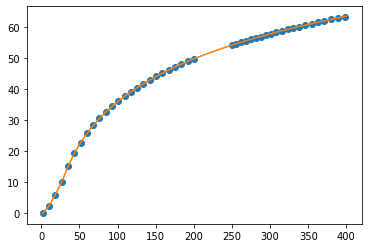

In [2541]:
xmax = 400
xnew = np.linspace(1,xmax,100)
vf_new = new_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)

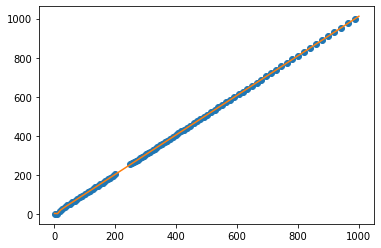

In [2542]:
xmax = 1000
xnew = np.linspace(1,xmax,100)
xp_new = new_sol.build_XP(xnew)

plt.plot(X[X < xmax], XP[X < xmax], 'o', xnew, xp_new)

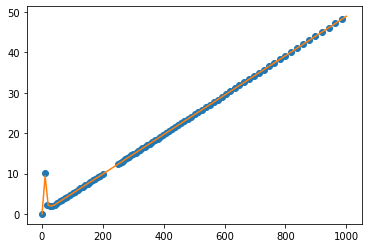

In [2543]:
cp_new = new_sol.build_CP(X = xnew)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)

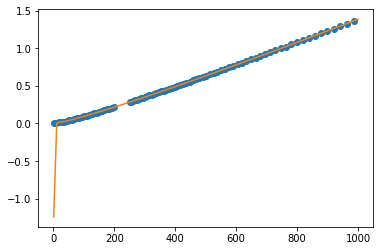

In [2544]:
wp_new = new_sol.build_WP(X = xnew)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)

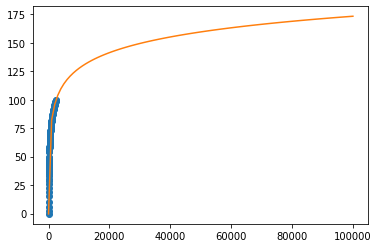

In [2545]:
xmax = 1e5
xnew = np.linspace(1,xmax,100)
vf_new = new_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)

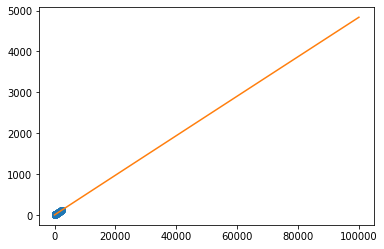

In [2546]:
cp_new = new_sol.build_CP(X = xnew)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)

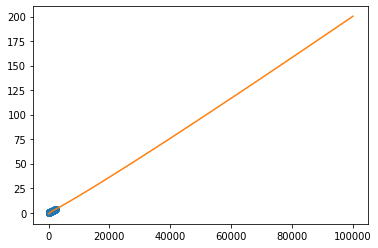

In [2547]:
wp_new = new_sol.build_WP(X = xnew)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)

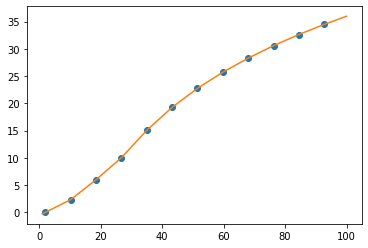

In [2548]:
xmax = 100
xnew = np.linspace(1,xmax,100)
vf_new = new_sol.build_VF(xnew)

plt.plot(X[X < xmax], VF[X < xmax], 'o', xnew, vf_new)

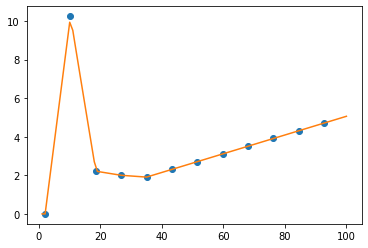

In [2549]:
cp_new = new_sol.build_CP(X = xnew)

plt.plot(X[X < xmax], CP[X < xmax], 'o', xnew, cp_new)

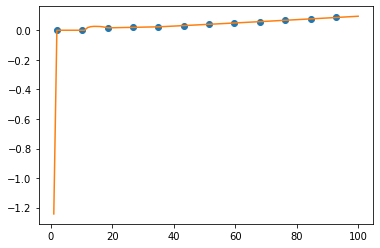

In [2550]:
wp_new = new_sol.build_WP(X = xnew)

plt.plot(X[X < xmax], WP[X < xmax], 'o', xnew, wp_new)

In [2551]:
new_sol.x_coeffs

array([-0.00203948,  1.01208409])